<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_2_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In This Notebook:

*   Text Classification (“emotion”)
*   EDA
*   Transformers as Feature Extractors USING AutoModel
*   UMAP
*   LOGISTIC REGRESSION
*   Fine-Tuning Transformers USING AutoModelForSequenceClassification
*   Error analysis

The final model https://huggingface.co/GV05/distilbert-base-uncased-finetuned-emotion

In [ ]:
!pip install transformers[sentencepiece] datasets

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
import pandas as pd

outputs = classifier("Im going to choke you with your cross necklace idiotic religious pig")
pd.DataFrame(outputs)

,label,score
0,NEGATIVE,0.999663


# The Dataset

In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
train_ds.features['label'].int2str(2), train_ds.features['label'].str2int('surprise'), 

('love', 5)

In [ ]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [ ]:
emotions.set_format(type="pandas")

In [ ]:
emotions["train"][0:5]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
df = emotions["train"][:]
df['label_name'] = df['label'].apply(lambda x: train_ds.features['label'].int2str(x))
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


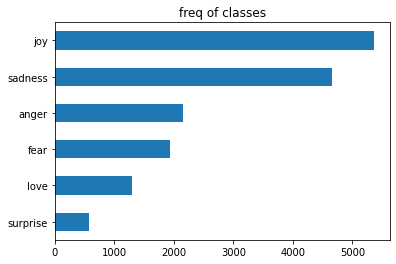

In [ ]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("freq of classes")
plt.show()

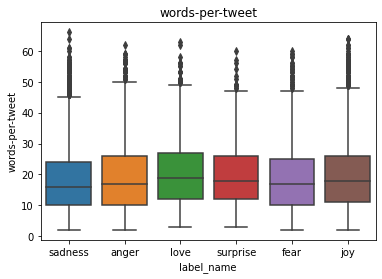

In [ ]:
import seaborn as sns
df["words-per-tweet"] = df['text'].str.split().apply(len)

sns.boxplot(data=df, x="label_name", y="words-per-tweet")
plt.title("words-per-tweet")
plt.show()

In [ ]:
emotions.reset_format()

# Tokenizing

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
encoded_text = tokenizer("some boting text")
encoded_text

{'input_ids': [101, 2070, 28516, 2075, 3793, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
tokens

['[CLS]', 'some', 'bot', '##ing', 'text', '[SEP]']

In [ ]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] some boting text [SEP]'

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)  # use also return_tensors="pt" 

"""
The padding argument controls padding. It can be a boolean or a string:

True or 'longest': pad to the longest sequence in the batch (no padding is applied if you only provide a single sequence).
'max_length': pad to a length specified by the max_length argument or the maximum length accepted by the model if no max_length is provided (max_length=None). Padding will still be applied if you only provide a single sequence.
False or 'do_not_pad': no padding is applied. This is the default behavior.
"""

In [ ]:
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size = None) #batch_size=None - applied on full dataset as a single batch

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [ ]:
print(emotions_encoded['train'][0]['input_ids'])

[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



# Training a Text Classifier

Transformers as Feature Extractors

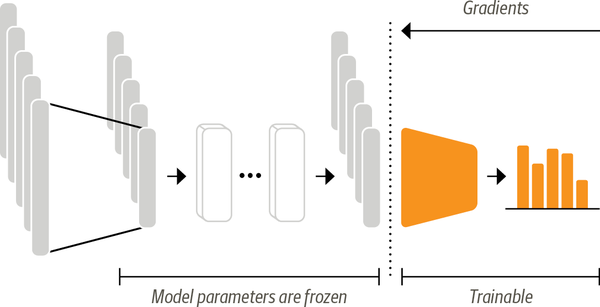

In [ ]:
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [ ]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [ ]:
outputs['last_hidden_state'].shape, outputs.last_hidden_state.size()

(torch.Size([1, 6, 768]), torch.Size([1, 6, 768]))

In [ ]:
outputs.last_hidden_state[:,0,:].size()  #for classification take the [CLS] token as the input feature

torch.Size([1, 768])

In [ ]:
def extract_hidden_states(batch):
  # move inputs to GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  return {"hidden_state" : last_hidden_state[:,0,:].cpu().numpy()}


In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", 'label'])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

# umap

In [ ]:
!pip install umap-learn

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll use the powerful UMAP algorithm to project the vectors down to 2D. Since UMAP works best when the features are scaled to lie in the [0,1] interval, we’ll first apply a MinMaxScaler and then use the UMAP implementation from the umap-learn library to reduce the hidden states:

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.486057,6.931165,0
1,-2.915224,6.237034,0
2,5.192639,3.398520,3
3,-2.393668,3.608036,2
4,-3.203321,4.144727,3


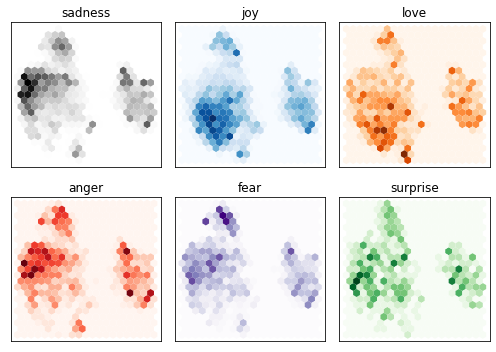

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# SKLEARN CLASSIFIER

In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6075

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

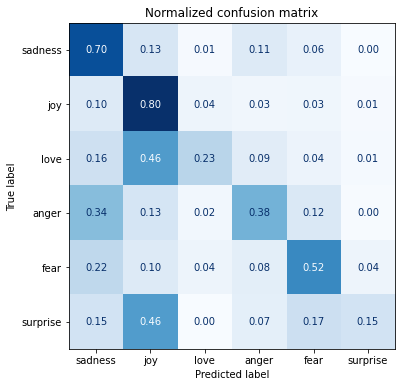

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# Fine-Tuning Transformers

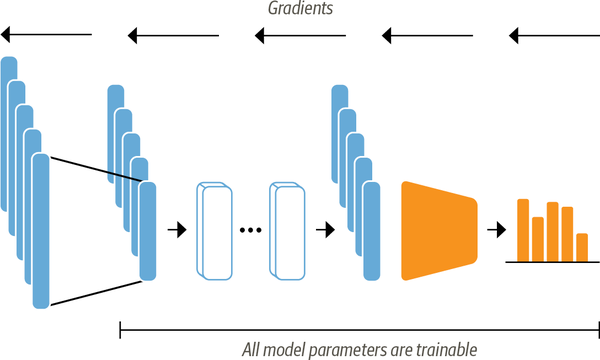

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

To monitor metrics during training, we need to define a compute_metrics() function for the Trainer. This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes) and needs to return a dictionary that maps each metric’s name to its value. For our application, we’ll compute the F1-score and the accuracy of the model as follows:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_prediction):
  labels = eval_prediction.label_ids
  preds = eval_prediction.predictions.argmax(-1)

  f1 = f1_score(y_true=labels, y_pred=preds, average='weighted')
  acc = accuracy_score(labels, preds)

  return {'accuracy':acc, 'f1':f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:708: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  FutureWarning,
Cloning https://huggingface.co/GV05/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.822700,0.314978,0.902000,0.899172
2,0.246000,0.214435,0.924500,0.924470


TrainOutput(global_step=500, training_loss=0.5343648986816406, metrics={'train_runtime': 246.0988, 'train_samples_per_second': 130.029, 'train_steps_per_second': 2.032, 'total_flos': 720342861696000.0, 'train_loss': 0.5343648986816406, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.2144346982240677,
 'test_accuracy': 0.9245,
 'test_f1': 0.9244695413548749,
 'test_runtime': 6.5205,
 'test_samples_per_second': 306.726,
 'test_steps_per_second': 4.908}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

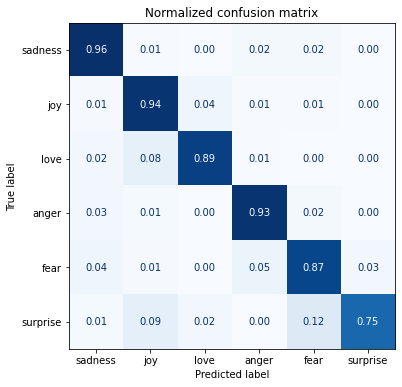

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

# sort the validation samples by the model loss.

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch): # a batch from DataSet

  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():

    outputs = model(**inputs)
    pred_label = outputs.logits.argmax(-1)
    loss = cross_entropy(outputs.logits, batch['label'].to(device), reduction="none") #the loss for each sample and not to all the batch.

  return {'loss': loss.cpu().numpy(), 
          'prediction_label': pred_label.cpu().numpy()}


In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", 'label'])

emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'prediction_label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
def label_int2str(row):
  return emotions_encoded['train'].features["label"].int2str(row)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "prediction_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["prediction_label"] = (df_test["prediction_label"].apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,prediction_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.665258
1274,i am going to several holiday parties and i ca...,joy,sadness,5.345197
765,i feel super awkward and out of place right now,joy,sadness,5.336473
1963,i called myself pro life and voted for perry w...,joy,sadness,5.315352
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.244720
882,i feel badly about reneging on my commitment t...,love,sadness,5.182999
465,i would eventually go in to these stores but i...,joy,fear,5.066467
1801,i feel that he was being overshadowed by the s...,love,sadness,5.009606
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.949708
1111,im lazy my characters fall into categories of ...,joy,fear,4.809582


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,prediction_label,loss
578,i got to christmas feeling positive about the ...,joy,joy,0.016005
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.016141
1226,im feeling terrific and in great shape im opti...,joy,joy,0.016290
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.016419
1012,i definitely succumbed to pre holiday sales bu...,joy,joy,0.016668
1310,i feel like an ungrateful asshole,sadness,sadness,0.016671
1513,i have also been getting back into my gym rout...,joy,joy,0.016735
530,i feel pretty safe but i do realize that we do...,joy,joy,0.016750
1028,im now winded at the end of a tough rally but ...,joy,joy,0.016769
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.016771


# Saving and sharing the model

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
from transformers import pipeline

model_id = "GV05/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, top_k=None)
preds

[{'label': 'LABEL_1', 'score': 0.9650061130523682},
 {'label': 'LABEL_2', 'score': 0.010750440880656242},
 {'label': 'LABEL_0', 'score': 0.008429591543972492},
 {'label': 'LABEL_5', 'score': 0.0063860551454126835},
 {'label': 'LABEL_3', 'score': 0.005515194498002529},
 {'label': 'LABEL_4', 'score': 0.003912688232958317}]

In [ ]:
data = {'label': [] , 'score': []}
for d in preds:
  str_label = label_int2str(int(d['label'].split("_")[1]))
  data['label'].append(str_label)
  data['score'].append(d['score'])
data

{'label': ['joy', 'love', 'sadness', 'surprise', 'anger', 'fear'],
 'score': [0.9650061130523682,
  0.010750440880656242,
  0.008429591543972492,
  0.0063860551454126835,
  0.005515194498002529,
  0.003912688232958317]}

In [ ]:
pred_df = pd.DataFrame(data)
pred_df

,label,score
0,joy,0.965006
1,love,0.010750
2,sadness,0.008430
3,surprise,0.006386
4,anger,0.005515
5,fear,0.003913


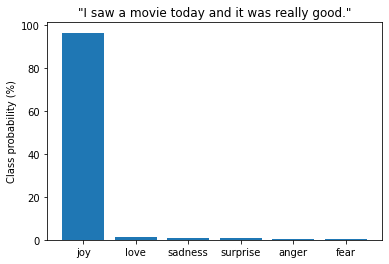

In [ ]:
plt.bar(pred_df["label"], 100 * pred_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()